An attempt to predict the win probability of the teams in a given match at the end of each over and to look at the important factors affecting the match output.

**Objective :** 
To predict the win probability of SRH at the end of each over for the finals of IPL season 2016.

**Training data :**
All other matches played during 2016 season 

Let us first import the necessary modules.!

In [2]:
import operator
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
%matplotlib inline

pd.set_option('display.max_columns', 50)            

Load the dataset and look at the top few rows to get an idea about the data. 

If you want to know more about the data, please look at the kernel here

In [2]:
data_path = "../input/"
score_df = pd.read_csv(data_path+"deliveries.csv")
match_df = pd.read_csv(data_path+"matches.csv")
score_df.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Kolkata Knight Riders,Royal Challengers Bangalore,1,1,SC Ganguly,BB McCullum,P Kumar,0,0,0,1,0,0,0,1,1,NaN,NaN,NaN
1,1,1,Kolkata Knight Riders,Royal Challengers Bangalore,1,2,BB McCullum,SC Ganguly,P Kumar,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Kolkata Knight Riders,Royal Challengers Bangalore,1,3,BB McCullum,SC Ganguly,P Kumar,0,1,0,0,0,0,0,1,1,NaN,NaN,NaN
3,1,1,Kolkata Knight Riders,Royal Challengers Bangalore,1,4,BB McCullum,SC Ganguly,P Kumar,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,Kolkata Knight Riders,Royal Challengers Bangalore,1,5,BB McCullum,SC Ganguly,P Kumar,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN


In this analysis, we are going to look at the matches played only during the latest season 2016. So let us subset the dataset to get only these rows. 

Also some matches are affected by rain and hence Duckworth-Lewis method are used for these matches and so using these matches for training our model might cause some error in our training and so let us neglect those matches as well.

In [3]:
# Let us take only the matches played in 2016 for this analysis #
match_df = match_df.ix[match_df.season==2016,:]
match_df = match_df.ix[match_df.dl_applied == 0,:]
match_df.head()

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
517,518,2016,Mumbai,2016-04-09,Mumbai Indians,Rising Pune Supergiants,Mumbai Indians,bat,normal,0,Rising Pune Supergiants,0,9,AM Rahane,Wankhede Stadium,HDPK Dharmasena,CK Nandan,NaN
518,519,2016,Kolkata,2016-04-10,Delhi Daredevils,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,9,AD Russell,Eden Gardens,S Ravi,C Shamshuddin,NaN
519,520,2016,Chandigarh,2016-04-11,Kings XI Punjab,Gujarat Lions,Gujarat Lions,field,normal,0,Gujarat Lions,0,5,AJ Finch,"Punjab Cricket Association IS Bindra Stadium, ...",AK Chaudhary,VA Kulkarni,NaN
520,521,2016,Bangalore,2016-04-12,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,field,normal,0,Royal Challengers Bangalore,45,0,AB de Villiers,M Chinnaswamy Stadium,HDPK Dharmasena,VK Sharma,NaN
521,522,2016,Kolkata,2016-04-13,Kolkata Knight Riders,Mumbai Indians,Mumbai Indians,field,normal,0,Mumbai Indians,0,6,RG Sharma,Eden Gardens,Nitin Menon,S Ravi,NaN


Okay. Now that we are done with the pre-processing, let us create the variables that are needed for building our model. 

Some of the important variables which I could think of are the following:

1. Runs scored in the last over
2. Wickets taken in the last over
3. Total score of the innings
4. Total wickets 
5. Target that the team is chasing down
6. Remaining target
7. Run rate
8. Required run rate
9. Difference between run rate and required run rate
10. Binary variables on whether the team for which we are predicting is batting team or bowling team

There are several other variables which we can create including

1. Team name
2. Opponent team name
3. Score in the last 'n' overs
4. Players who are batting
5. Player who is bowling and so on.

But ours is a good set of variables to start with.



In [4]:
# runs and wickets per over #
score_df = pd.merge(score_df, match_df[['id','season', 'winner', 'result', 'dl_applied', 'team1', 'team2']], left_on='match_id', right_on='id')
score_df.player_dismissed.fillna(0, inplace=True)
score_df['player_dismissed'].ix[score_df['player_dismissed'] != 0] = 1
train_df = score_df.groupby(['match_id', 'inning', 'over', 'team1', 'team2', 'batting_team', 'winner'])[['total_runs', 'player_dismissed']].agg(['sum']).reset_index()
train_df.columns = train_df.columns.get_level_values(0)

# innings score and wickets #
train_df['innings_wickets'] = train_df.groupby(['match_id', 'inning'])['player_dismissed'].cumsum()
train_df['innings_score'] = train_df.groupby(['match_id', 'inning'])['total_runs'].cumsum()
train_df.head()

# Get the target column #
temp_df = train_df.groupby(['match_id', 'inning'])['total_runs'].sum().reset_index()
temp_df = temp_df.ix[temp_df['inning']==1,:]
temp_df['inning'] = 2
temp_df.columns = ['match_id', 'inning', 'score_target']
train_df = train_df.merge(temp_df, how='left', on = ['match_id', 'inning'])
train_df['score_target'].fillna(-1, inplace=True)

# get the remaining target #
def get_remaining_target(row):
    if row['score_target'] == -1.:
        return -1
    else:
        return row['score_target'] - row['innings_score']

train_df['remaining_target'] = train_df.apply(lambda row: get_remaining_target(row),axis=1)

# get the run rate #
train_df['run_rate'] = train_df['innings_score'] / train_df['over']

# get the remaining run rate #  
def get_required_rr(row):
    if row['remaining_target'] == -1:
        return -1.
    elif row['over'] == 20:
        return 99
    else:
        return row['remaining_target'] / (20-row['over'])
    
train_df['required_run_rate'] = train_df.apply(lambda row: get_required_rr(row), axis=1)

def get_rr_diff(row): 
    if row['inning'] == 1:
        return -1
    else:
        return row['run_rate'] - row['required_run_rate']
    
train_df['runrate_diff'] = train_df.apply(lambda row: get_rr_diff(row), axis=1)
train_df['is_batting_team'] = (train_df['team1'] == train_df['batting_team']).astype('int')
train_df['target'] = (train_df['team1'] == train_df['winner']).astype('int')

train_df.head()

/opt/conda/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,match_id,inning,over,team1,team2,batting_team,winner,total_runs,player_dismissed,innings_wickets,innings_score,score_target,remaining_target,run_rate,required_run_rate,runrate_diff,is_batting_team,target
0,518,1,1,Mumbai Indians,Rising Pune Supergiants,Mumbai Indians,Rising Pune Supergiants,8,0,0,8,-1.0,-1.0,8.000000,-1.0,-1.0,1,0
1,518,1,2,Mumbai Indians,Rising Pune Supergiants,Mumbai Indians,Rising Pune Supergiants,4,1,1,12,-1.0,-1.0,6.000000,-1.0,-1.0,1,0
2,518,1,3,Mumbai Indians,Rising Pune Supergiants,Mumbai Indians,Rising Pune Supergiants,8,0,1,20,-1.0,-1.0,6.666667,-1.0,-1.0,1,0
3,518,1,4,Mumbai Indians,Rising Pune Supergiants,Mumbai Indians,Rising Pune Supergiants,9,1,2,29,-1.0,-1.0,7.250000,-1.0,-1.0,1,0
4,518,1,5,Mumbai Indians,Rising Pune Supergiants,Mumbai Indians,Rising Pune Supergiants,1,2,4,30,-1.0,-1.0,6.000000,-1.0,-1.0,1,0


Now let us split the data and keep the final match as our validation sample.

In [5]:
x_cols = ['inning', 'over', 'total_runs', 'player_dismissed', 'innings_wickets', 'innings_score', 'score_target', 'remaining_target', 'run_rate', 'required_run_rate', 'runrate_diff', 'is_batting_team']

# let us take all the matches but for the final as development sample and final as val sample #
val_df = train_df.ix[train_df.match_id == 577,:]
dev_df = train_df.ix[train_df.match_id != 577,:]

# create the input and target variables #
dev_X = np.array(dev_df[x_cols[:]])
dev_y = np.array(dev_df['target'])
val_X = np.array(val_df[x_cols[:]])[:-1,:]
val_y = np.array(val_df['target'])[:-1]
print(dev_X.shape, dev_y.shape)
print(val_X.shape, val_y.shape)

(2135, 12) (2135,)
(39, 12) (39,)


We shall use Xgboost for our modeling. Let us create a custom function for the same.

In [6]:
# define the function to create the model #
def runXGB(train_X, train_y, seed_val=0):
    param = {}
    param['objective'] = 'binary:logistic'
    param['eta'] = 0.05
    param['max_depth'] = 8
    param['silent'] = 1
    param['eval_metric'] = "auc"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = 100

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    model = xgb.train(plst, xgtrain, num_rounds)
    return model

Now we are all set to build our model and make predictions. 

In [7]:
# let us build the model and get predcition for the final match #
model = runXGB(dev_X, dev_y)
xgtest = xgb.DMatrix(val_X)
preds = model.predict(xgtest)

**Important variables:**

Now that we have built our model, let us look at the important variables that contribute to the win.

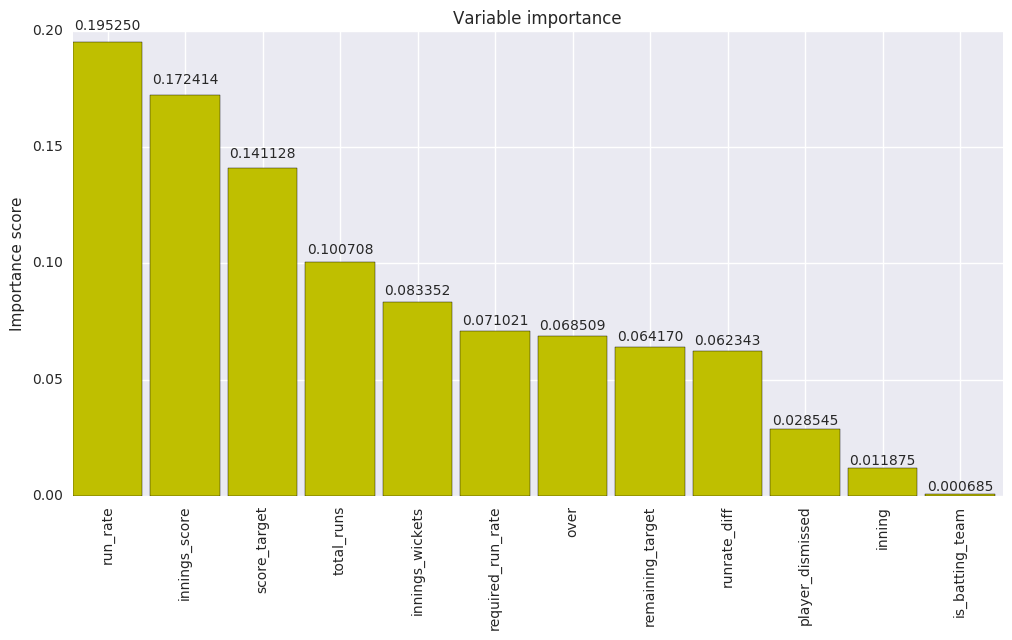

In [8]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i,feat))
    outfile.close()

create_feature_map(x_cols)
importance = model.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1), reverse=True)
imp_df = pd.DataFrame(importance, columns=['feature','fscore'])
imp_df['fscore'] = imp_df['fscore'] / imp_df['fscore'].sum()

# create a function for labeling #
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.02*height,
                '%f' % float(height),
                ha='center', va='bottom')
        
labels = np.array(imp_df.feature.values)
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,6))
rects = ax.bar(ind, np.array(imp_df.fscore.values), width=width, color='y')
ax.set_xticks(ind+((width)/2.))
ax.set_xticklabels(labels, rotation='vertical')
ax.set_ylabel("Importance score")
ax.set_title("Variable importance")
autolabel(rects)
plt.show()

**Run rate** is the most important predictor of the win. It makes sense since if the run rate is high, the team have higher tendency to win.

**Innings score** is the second most important predictor with **target score** being the third.

**Win probability at the end of each over for SRH:**

Now that we had a look at the important predictor variables, let us check the win probability predictions for the final match.

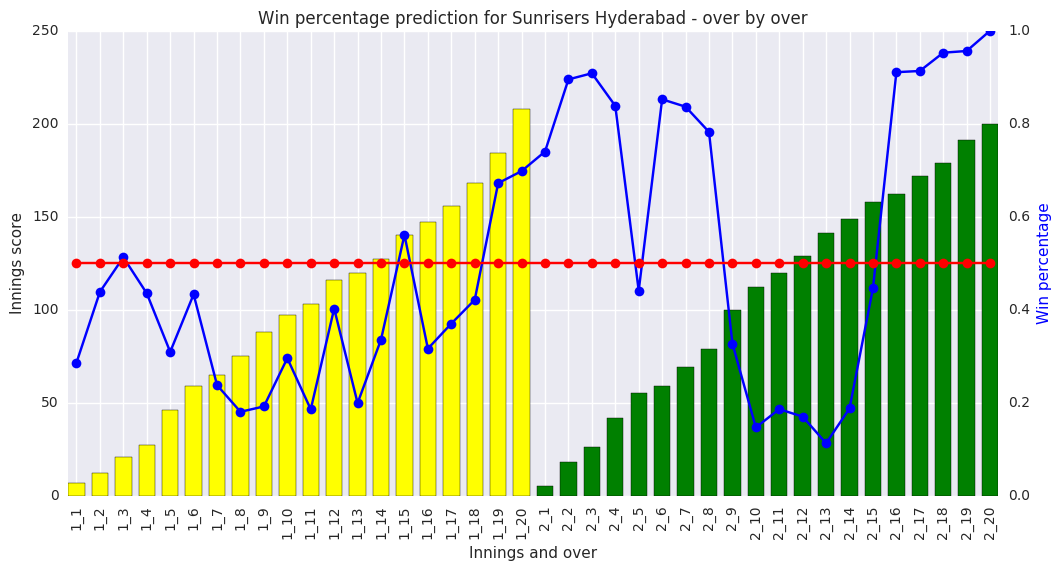

In [9]:
out_df = pd.DataFrame({'Team1':val_df.team1.values})
out_df['is_batting_team'] = val_df.is_batting_team.values
out_df['innings_over'] = np.array(val_df.apply(lambda row: str(row['inning']) + "_" + str(row['over']), axis=1))
out_df['innings_score'] = val_df.innings_score.values
out_df['innings_wickets'] = val_df.innings_wickets.values
out_df['score_target'] = val_df.score_target.values
out_df['total_runs'] = val_df.total_runs.values
out_df['predictions'] = list(preds)+[1]

fig, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()
labels = np.array(out_df['innings_over'])
ind = np.arange(len(labels))
width = 0.7
rects = ax1.bar(ind, np.array(out_df['innings_score']), width=width, color=['yellow']*20 + ['green']*20)
ax1.set_xticks(ind+((width)/2.))
ax1.set_xticklabels(labels, rotation='vertical')
ax1.set_ylabel("Innings score")
ax1.set_xlabel("Innings and over")
ax1.set_title("Win percentage prediction for Sunrisers Hyderabad - over by over")

ax2.plot(ind+0.35, np.array(out_df['predictions']), color='b', marker='o')
ax2.plot(ind+0.35, np.array([0.5]*40), color='red', marker='o')
ax2.set_ylabel("Win percentage", color='b')
ax2.set_ylim([0,1])
ax2.grid(b=False)
plt.show()

Yellow bar represents the scores in the corresponding overs played by SRH while green is for RCB. 

Red line represents the equal win probability and blue line represents the win probability of SRH at the end of each over. 

As we can see, it was generally below 0.5 for most part of the first innings, but things changed in the last two overs. Then it was continuously above 0.5 for the first 8 overs and was below 0.5 till 15th over. This makes us wonder what has happened in those particular overs which caused the shift in predictions.

So let us look at the same graph by using the number of runs scored in that over in place of overall runs.

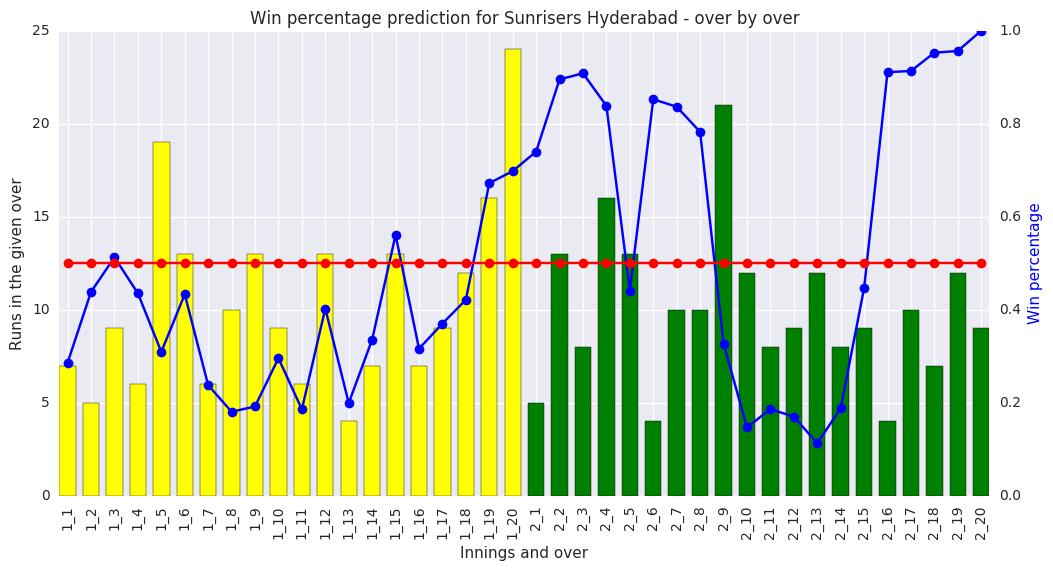

In [10]:
fig, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()
labels = np.array(out_df['innings_over'])
ind = np.arange(len(labels))
width = 0.7
rects = ax1.bar(ind, np.array(out_df['total_runs']), width=width, color=['yellow']*20 + ['green']*20)
ax1.set_xticks(ind+((width)/2.))
ax1.set_xticklabels(labels, rotation='vertical')
ax1.set_ylabel("Runs in the given over")
ax1.set_xlabel("Innings and over")
ax1.set_title("Win percentage prediction for Sunrisers Hyderabad - over by over")

ax2.plot(ind+0.35, np.array(out_df['predictions']), color='b', marker='o')
ax2.plot(ind+0.35, np.array([0.5]*40), color='red', marker='o')
ax2.set_ylabel("Win percentage", color='b')
ax2.set_ylim([0,1])
ax2.grid(b=False)
plt.show()

Hurray.! Things are more clear now.

As we can see, SRH has scored lot of runs in the last two overs (16 and 24),  which clearly gave them an edge.

Also the scoring rate of RCB was very low in the first 8 overs which made the win probability to hover over 0.5. Then 9th over changed the dynamics since RCB scored 21 runs in that over clearly giving them an edge. 

Wickets that went away in the 13th to 15th overs helped SRH increase the win percentage. In 16th over SRH conceded only 4 runs which shifted the game in their favour.!

